# XGBoost Tuning (Descriptors + Fingerprints)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna
from pyscf import gto, scf


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [ ]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog('rdApp.*')
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=tt_bits)
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))
    
    RDLogger.EnableLog('rdApp.*')

    return feats


def prepare_3d_molecule(mol):
    # Create 3D molecule
    if mol is None:
        return None

    mol3d = Chem.AddHs(mol)

    try:
        # Calculate 3D coordinates and energy
        AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol3d, maxIters=200)
    except Exception:
        return None

    return mol3d

from pyscf import gto, scf

def compute_homo_lumo_pyscf_fast(mol):
    feats = {
        "HOMO_eV": np.nan,
        "LUMO_eV": np.nan,
        "HL_Gap_eV": np.nan,
    }

    if mol is None:
        return feats

    # Create 3D molecule
    mol3d = prepare_3d_molecule(mol)
    if mol3d is None:
        return feats

    # 3D coordinates in XYZ format
    conf = mol3d.GetConformer()
    lines = []
    for atom in mol3d.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        lines.append(f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}")
    xyz = "\n".join(lines)

    # Calculate charge
    total_charge = sum(a.GetFormalCharge() for a in mol3d.GetAtoms())

    try:
        # Creates quantum mechanical system
        mol_qc = gto.M(
            atom=xyz,
            basis="sto-3g",
            unit="Angstrom",
            charge=total_charge,
            spin=0,
        )

        # Quantum electron calculation
        mf = scf.RHF(mol_qc).density_fit()
        mf.verbose = 0 
        mf.conv_tol = 1e-5
        mf.max_cycle = 30

        mf.run()

        # Extract HOMO and LUMO
        eps = mf.mo_energy
        n_electrons = mol_qc.nelectron
        homo_idx = n_electrons // 2 - 1
        lumo_idx = homo_idx + 1

        homo = eps[homo_idx]
        lumo = eps[lumo_idx]

        hartree_to_ev = 27.211386245988
        feats["HOMO_eV"] = homo * hartree_to_ev
        feats["LUMO_eV"] = lumo * hartree_to_ev
        feats["HL_Gap_eV"] = (lumo - homo) * hartree_to_ev

    except Exception:
        pass

    return feats

## Dataset Processing

In [5]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Fingerprints
    fp_feats = calculate_fingerprints(molecule)

    # HOMO / LUMO / gap from PySCF
    homo_lumo_feats = compute_homo_lumo_pyscf_fast(molecule)

    # Merge all feature dicts
    all_feats = {**desc_feats, **fp_feats, **homo_lumo_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 8592
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labut

## Base Model Train

In [12]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.7273
Precision: 0.8000
Recall:    0.6667
F1 score:  0.7273
ROC AUC:   0.7852

Classification report:
              precision    recall  f1-score   support

           0      0.667     0.800     0.727        15
           1      0.800     0.667     0.727        18

    accuracy                          0.727        33
   macro avg      0.733     0.733     0.727        33
weighted avg      0.739     0.727     0.727        33



## Feature Selection

PermutationExplainer explainer: 130it [02:05,  1.00s/it]                         
/tmp/ipykernel_76298/582230141.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


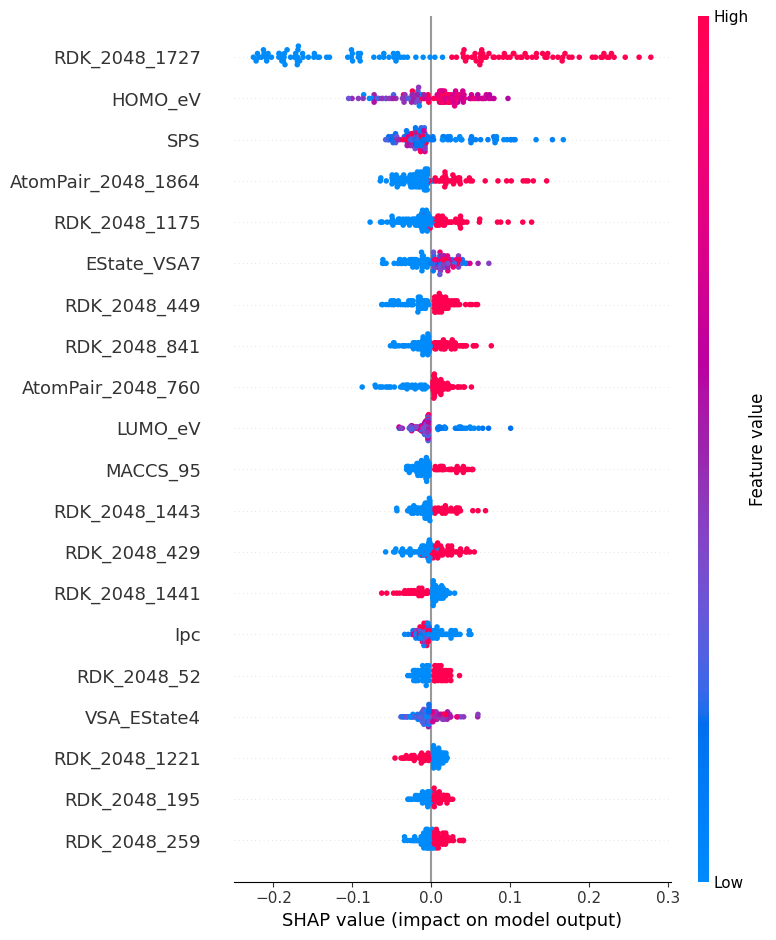

In [7]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 20)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

## SHAP Features

In [13]:
shap_features.head(20)

RDK_2048_1727         0.128137
HOMO_eV               0.036038
SPS                   0.033503
AtomPair_2048_1864    0.029325
RDK_2048_1175         0.024328
EState_VSA7           0.020802
RDK_2048_449          0.020375
RDK_2048_841          0.019130
AtomPair_2048_760     0.019101
LUMO_eV               0.016896
MACCS_95              0.016496
RDK_2048_1443         0.015349
RDK_2048_429          0.014871
RDK_2048_1441         0.013414
Ipc                   0.013165
RDK_2048_52           0.013090
VSA_EState4           0.013074
RDK_2048_1221         0.011879
RDK_2048_195          0.010536
RDK_2048_259          0.010399
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.759495  0.778540    0.790742
1     10     0.751683  0.760695    0.791099
2     15     0.790385  0.810372    0.847969
3     20     0.751683  0.770425    0.823725
4     25     0.782452  0.808934    0.843347

Best number of features by CV F1: 15
Top_N          15.000000
CV_Accuracy     0.790385
CV_F1           0.810372
CV_ROC_AUC      0.847969
Name: 2, dtype: float64


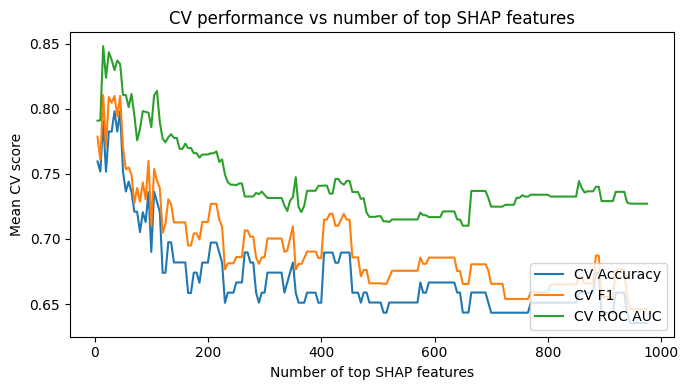

In [14]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1, 5):
    top_feats = shap_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## XGB Features

In [15]:
xgb_features.head(20)

RDK_2048_1727         0.073109
RDK_2048_1282         0.047804
RDK_2048_1711         0.043193
RDK_2048_1175         0.032467
RDK_2048_1659         0.031344
PEOE_VSA12            0.029694
SlogP_VSA4            0.028886
EState_VSA6           0.026238
AtomPair_2048_1380    0.026019
Torsion_2048_408      0.024679
RDK_2048_1183         0.023822
VSA_EState9           0.021951
RDK_2048_1375         0.021038
RDK_2048_1605         0.020891
RDK_2048_272          0.019975
fr_NH1                0.019208
AtomPair_2048_1864    0.019179
MACCS_118             0.019085
RDK_2048_662          0.016418
RDK_2048_15           0.016180
dtype: float32


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.821635  0.839209    0.851975
1     10     0.798077  0.819444    0.874328
2     15     0.806130  0.820083    0.853557
3     20     0.790385  0.806004    0.884314
4     25     0.759375  0.767647    0.868207

Best number of features by CV F1: 5
Top_N          5.000000
CV_Accuracy    0.821635
CV_F1          0.839209
CV_ROC_AUC     0.851975
Name: 0, dtype: float64


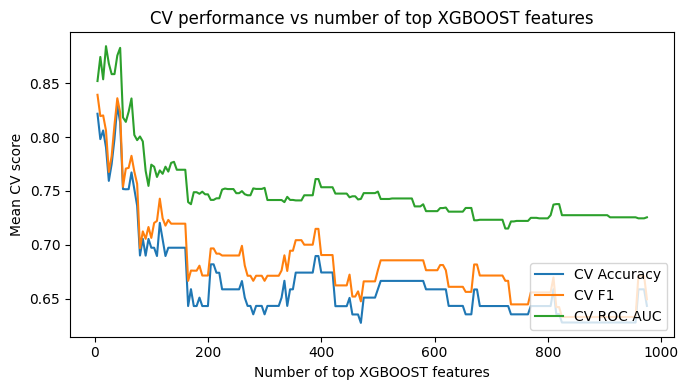

In [16]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(xgb_features) + 1, 5):
    top_feats = xgb_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_xgb = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top XGBOOST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top XGBOOST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features

In [17]:
kbest_features.head(20)

RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_865     26.473703
RDK_2048_1387    26.473703
RDK_2048_354     25.784260
RDK_2048_84      24.605035
RDK_2048_233     24.605035
RDK_2048_1993    24.507216
RDK_2048_808     24.507216
RDK_2048_1184    24.505004
RDK_2048_1443    23.567010
RDK_2048_534     23.567010
RDK_2048_195     23.449508
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.743750  0.737193    0.808620
1     10     0.705409  0.716165    0.765147
2     15     0.689784  0.692308    0.777472
3     20     0.674519  0.695798    0.790889
4     25     0.697716  0.706787    0.795763

Best number of features by CV F1: 90
Top_N          90.000000
CV_Accuracy     0.736298
CV_F1           0.756536
CV_ROC_AUC      0.778039
Name: 17, dtype: float64


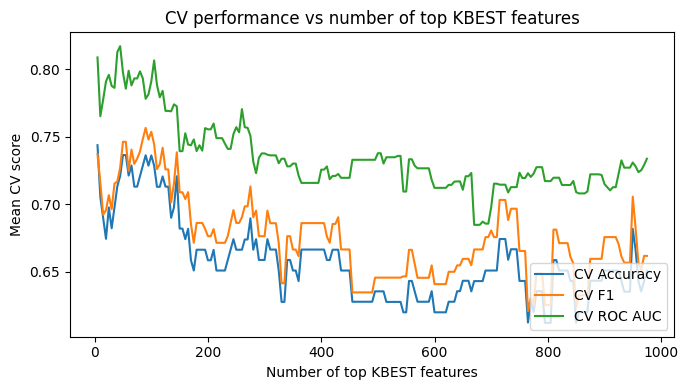

In [18]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1, 5):
    top_feats = kbest_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features

In [20]:
lasso_features.head(20)

AtomPair_2048_760     1.172084
RDK_2048_1827         0.974770
RDK_2048_841          0.951552
MACCS_95              0.864491
AtomPair_2048_1864    0.576837
VSA_EState9           0.575129
RDK_2048_1441         0.559231
RDK_2048_84           0.549382
RDK_2048_1421         0.501014
RDK_2048_680          0.473817
RDK_2048_1256         0.460561
RDK_2048_52           0.442809
RDK_2048_1443         0.369413
AtomPair_2048_1018    0.369204
RDK_2048_1061         0.336236
RDK_2048_1923         0.315271
RDK_2048_1221         0.314997
RDK_2048_846          0.305337
RDK_2048_933          0.304151
RDK_2048_449          0.301997
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.813822  0.828869    0.901085
1     10     0.806250  0.817562    0.871176
2     15     0.844712  0.859524    0.897185
3     20     0.829207  0.843795    0.918838
4     25     0.875481  0.893275    0.943501

Best number of features by CV F1: 25
Top_N          25.000000
CV_Accuracy     0.875481
CV_F1           0.893275
CV_ROC_AUC      0.943501
Name: 4, dtype: float64


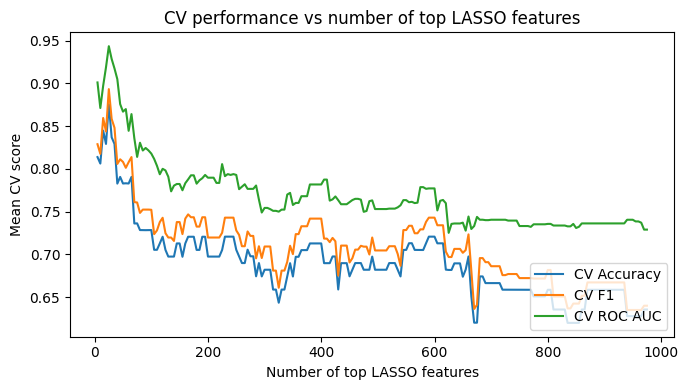

In [21]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1, 5):
    top_feats = lasso_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features

In [22]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.7273
Precision: 0.8000
Recall:    0.6667
F1 score:  0.7273
ROC AUC:   0.7037


## Model XGB Features

In [23]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (XGB) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (XGB) on test:
Accuracy:  0.6667
Precision: 0.7333
Recall:    0.6111
F1 score:  0.6667
ROC AUC:   0.7685


## Model KBEST Features

In [24]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.6667
Precision: 0.7692
Recall:    0.5556
F1 score:  0.6452
ROC AUC:   0.6815


## Model LASSO Features

In [25]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.6667
Precision: 0.7059
Recall:    0.6667
F1 score:  0.6857
ROC AUC:   0.7074


## Model SHAP Features Tuning

In [26]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),

    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 100. Best value: 0.882899: 100%|██████████| 200/200 [00:07<00:00, 26.63it/s]



Best trial:
  Value: 0.8828991596638656
  Params:
    n_estimators: 101
    max_depth: 6
    learning_rate: 0.05160247932231853
    subsample: 0.665840515478128
    colsample_bytree: 0.7686248546532218
    min_child_weight: 4.428576866441212
    gamma: 1.3197397254040195
    reg_lambda: 1.7652554391565083
    reg_alpha: 1.7554324982235807

Final Optuna model (SHAP):
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7019


## Model XGB Features Tuning

In [29]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (XGB):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 148. Best value: 0.883669: 100%|██████████| 200/200 [00:07<00:00, 27.11it/s]


Best trial:
  Value: 0.8836694677871149
  Params:
    n_estimators: 61
    max_depth: 6
    learning_rate: 0.05608451655952069
    subsample: 0.5424369860655771
    colsample_bytree: 0.6135463477109722
    min_child_weight: 1.1065735431503174
    gamma: 1.770743976970372
    reg_lambda: 0.020989365274072608
    reg_alpha: 0.7152040602334189

Final Optuna model (XGB):
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7315


## Model KBEST Features Tuning

In [30]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 161. Best value: 0.848207: 100%|██████████| 200/200 [00:10<00:00, 18.86it/s]



Best trial:
  Value: 0.8482072829131653
  Params:
    n_estimators: 54
    max_depth: 5
    learning_rate: 0.06442355061772023
    subsample: 0.5414934514202051
    colsample_bytree: 0.7724177325103976
    min_child_weight: 1.2236062183065433
    gamma: 0.9825461967139081
    reg_lambda: 0.21984314747448902
    reg_alpha: 0.16024135829648864

Final Optuna model (KBEST):
Accuracy:  0.5758
Precision: 0.6429
Recall:    0.5000
F1 score:  0.5625
ROC AUC:   0.7185


## Model LASSO Features Tuning

In [31]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),

    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 33. Best value: 0.950224: 100%|██████████| 200/200 [00:07<00:00, 25.15it/s]



Best trial:
  Value: 0.9502240896358543
  Params:
    n_estimators: 148
    max_depth: 4
    learning_rate: 0.2610588337468686

Final Optuna model (LASSO):
Accuracy:  0.6667
Precision: 0.7059
Recall:    0.6667
F1 score:  0.6857
ROC AUC:   0.7222


## Model SHAP Features Tuning + Early Stopping

In [32]:
# Feature selection
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna objective with CV + early stopping
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 40),
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    fold_aucs = []

    for train_idx, valid_idx in cv.split(X_train_fs, y_train):
        X_tr, X_val = X_train_fs.iloc[train_idx], X_train_fs.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_val_pred = model.predict_proba(X_val)[:, 1]
        fold_auc = roc_auc_score(y_val, y_val_pred)
        fold_aucs.append(fold_auc)

    return np.mean(fold_aucs)


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params.copy()

# Extract early_stopping_rounds from tuned params
best_esr = best_params.pop("early_stopping_rounds", 30)

final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    early_stopping_rounds=best_esr,
    **best_params
)

# Use an internal validation split for early stopping
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_train_fs, y_train, test_size=0.2, stratify=y_train, random_state=42
)

final_model.fit(
    X_tr_final,
    y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    verbose=False
)

# Evaluate on test set
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO + CV + Early Stopping):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 172. Best value: 0.917773: 100%|██████████| 200/200 [00:18<00:00, 10.85it/s]



Best trial:
  Value: 0.9177731092436975
  Params:
    n_estimators: 142
    max_depth: 5
    learning_rate: 0.0860287585281157
    subsample: 0.5731835835749959
    colsample_bytree: 0.7560008202081179
    min_child_weight: 1.1534261673777038
    gamma: 0.14045361627236214
    reg_lambda: 1.3922671398279731
    reg_alpha: 0.023800218254932254
    early_stopping_rounds: 36

Final Optuna model (LASSO + CV + Early Stopping):
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7000


## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(80), 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Accuracy: 0.697 | ROC-AUC: 0.657

=== Testing top 6 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(20), 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.758 | ROC-AUC: 0.726

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(60), 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Accuracy: 0.697 | ROC-AUC: 0.689

=== Testing top 8 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(40), 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.697 | ROC-AUC: 0.715

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(80), 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.693

=== Testing top 10 features

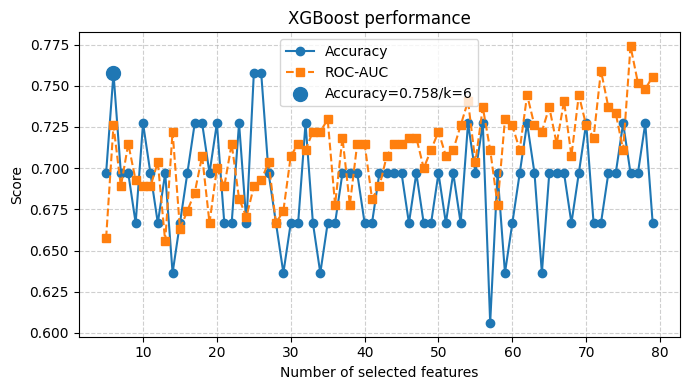


Accuracy = 0.758/ROC-AUC = 0.726/k = 6


In [33]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(120), 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Accuracy: 0.667 | ROC-AUC: 0.731

=== Testing top 6 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(60), 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Accuracy: 0.667 | ROC-AUC: 0.763

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': np.int64(120), 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.576 | ROC-AUC: 0.722

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(40), 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Accuracy: 0.636 | ROC-AUC: 0.770

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(40), 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Accuracy: 0.667 | ROC-AUC: 0.759

=== Testing top 10 featu

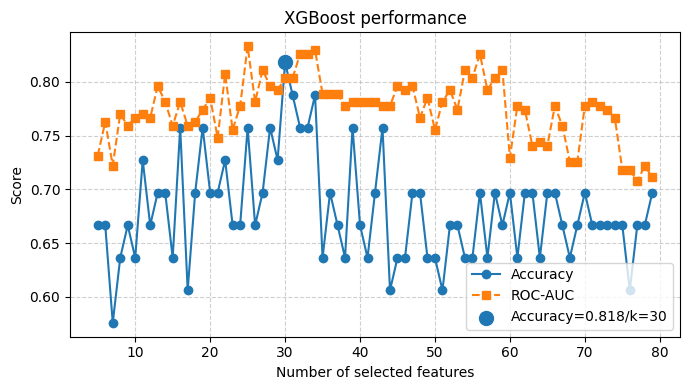


Accuracy = 0.818/ROC-AUC = 0.804/k = 30


In [34]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(120), 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.667 | ROC-AUC: 0.641

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(140), 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.687

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': np.int64(120), 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.606 | ROC-AUC: 0.665

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(60), 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.674

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(80), 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.636 | ROC-AUC: 0.681

=== Testing top 10 fea

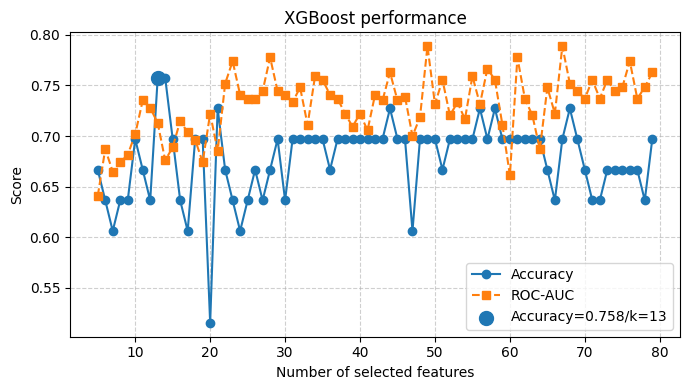


Accuracy = 0.758/ROC-AUC = 0.713/k = 13


In [36]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(100), 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.545 | ROC-AUC: 0.617

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(100), 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.624

=== Testing top 7 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(120), 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.624

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(140), 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Accuracy: 0.667 | ROC-AUC: 0.635

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': np.int64(140), 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.652

=== Testing top 10 feat

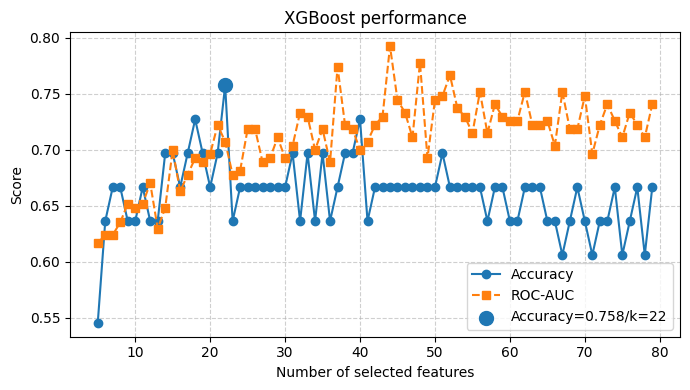


Accuracy = 0.758/ROC-AUC = 0.707/k = 22


In [41]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")